<a href="https://colab.research.google.com/github/yacanom/MAIA/blob/main/MLNS_Modelado_de_t%C3%B3picos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim

# 0. Importación de paquetes

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from textblob import TextBlob
import scipy.stats as stats

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Modelado de Tópicos con Machine Learning No Supervisado: Análisis de Noticias en Español**

Este notebook busca exponer cómo se trabaja **el modelo de tópicos** desde el machine learning no supervisado. El modelado de tópicos es una técnica que permite descubrir la estructura temática latente en grandes colecciones de texto.
A diferencia de los modelos supervisados, no requiere etiquetas predefinidas, lo que lo hace ideal para explorar datasets de texto sin categorizar. A

En este caso, utilizaremos un conjunto de datos de noticias en español (spanish-news-classification) que fue obtenido por scraping para el **Datatón 2022 de Bancolombia**. El propósito original del dataset era entrenar modelos supervisados de recomendación en categorías como Macroeconomía, Sostenibilidad,
Innovación, Regulaciones, Alianzas, Reputación y Otros.

Nuestro objetivo será aplicar técnicas no supervisadas para identificar los temas principales que emergen de estas noticias.

Exploraremos dos de los modelos de tópicos más comunes: **Latent Semantic Analysis (LSA) y Latent Dirichlet Allocation (LDA)**, y discutiremos las mejores prácticas para la búsqueda de hiperparámetros en cada uno.

# **Preparación de los Datos**

## Preprocesamiento y Vectorización del Texto

El preprocesamiento para el modelado de tópicos implica transformar el texto sin estructurar en una representación numérica que los algoritmos puedan procesar. Para este fin, utilizaremos **CountVectorizer** de **Scikit-learn**. Este proceso convierte cada documento en un vector que cuenta la frecuencia de cada palabra. Es crucial eliminar las 'stop words' (palabras comunes como 'el', 'la', 'un') para que el modelo se enfoque en palabras más significativas para la identificación de tópicos.

El resultado será una Matriz Documento-Término (DTM), donde las filas representan documentos y las columnas representan palabras del vocabulario. También se mostrará el vocabulario resultante.

In [3]:
url = 'https://raw.githubusercontent.com/yacanom/MAIA/refs/heads/main/df_total.csv'

try:
    df = pd.read_csv(url)
    print(f"Dataset cargado correctamente con {df.shape[0]} filas y {df.shape[1]} columnas.")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")

df.head()

Dataset cargado correctamente con 1217 filas y 3 columnas.


,url,news,Type
0,https://www.larepublica.co/redirect/post/3201905,Durante el foro La banca articulador empresari...,Otra
1,https://www.larepublica.co/redirect/post/3210288,El regulador de valores de China dijo el domin...,Regulaciones
2,https://www.larepublica.co/redirect/post/3240676,En una industria históricamente masculina como...,Alianzas
3,https://www.larepublica.co/redirect/post/3342889,Con el dato de marzo el IPC interanual encaden...,Macroeconomia
4,https://www.larepublica.co/redirect/post/3427208,Ayer en Cartagena se dio inicio a la versión n...,Otra


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     1217 non-null   object
 1   news    1217 non-null   object
 2   Type    1217 non-null   object
dtypes: object(3)
memory usage: 28.7+ KB


In [5]:
data = df[['news']]
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    1217 non-null   object
dtypes: object(1)
memory usage: 9.6+ KB
None


,news
0,Durante el foro La banca articulador empresari...
1,El regulador de valores de China dijo el domin...
2,En una industria históricamente masculina como...
3,Con el dato de marzo el IPC interanual encaden...
4,Ayer en Cartagena se dio inicio a la versión n...


El único paso de preprocesamiento necesario en nuestro caso es la construcción de características, en la que tomamos el texto de las noticias y los representamos en algún espacio de características manejable. En la práctica, esto significa simplemente convertir cada cadena en un vector numérico.

In [11]:
# Vectorizacion con stopwords en Spanish
spanish_stop_words = stopwords.words('spanish')

def preprocess(text):
    # Minúsculas
    text = text.lower()
    # Tokenización simple
    tokens = text.split()
    # Eliminar stopwords
    tokens = [t for t in tokens if t not in spanish_stop_words]
    return " ".join(tokens)

data['clean_news'] = df['news'].astype(str).apply(preprocess)
data[['news','clean_news']].head()

/tmp/ipython-input-1066451209.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_news'] = df['news'].astype(str).apply(preprocess)


,news,clean_news
0,Durante el foro La banca articulador empresari...,foro banca articulador empresarial desarrollo ...
1,El regulador de valores de China dijo el domin...,regulador valores china dijo domingo buscará c...
2,En una industria históricamente masculina como...,industria históricamente masculina aviación vi...
3,Con el dato de marzo el IPC interanual encaden...,dato marzo ipc interanual encadena decimoquint...
4,Ayer en Cartagena se dio inicio a la versión n...,ayer cartagena dio inicio versión número 56 co...


In [12]:
vectorizer = CountVectorizer(stop_words=spanish_stop_words, max_features=40000)
document_term_matrix = vectorizer.fit_transform(data['clean_news'])

# Obtener el vocabulario
vocabulary = vectorizer.get_feature_names_out()

# Ejemplo: Obtener el vector de un texto específico
text_to_vectorize = data['news'].iloc[0]  # Obtener el primer texto
text_vector = vectorizer.transform([text_to_vectorize]).toarray()

print('Vector del texto:', text_vector)
print('Vocabulario:', vocabulary)

Vector del texto: [[0 0 0 ... 0 0 0]]
Vocabulario: ['00' '000' '000a' ... 'úrsula' 'útil' 'útiles']


# **Modelamiento**

## **Latent Semantic Analysis**

LSA es una técnica de procesamiento de lenguaje natural que utiliza la descomposición en valores singulares (SVD) para analizar las relaciones entre un conjunto de documentos y los términos que contienen. Su objetivo es reducir la dimensionalidad de la matriz documento-término, capturando la estructura semántica latente y los temas subyacentes. Aquí, cada tópico se derivará de patrones de co-ocurrencia de palabras.

Procederemos a aplicar LSA para identificar un número inicial de tópicos y luego examinaremos las palabras más representativas de cada uno.

In [13]:
#Escogemos un valor predeterminado de 4 tópicos
n_topics = 4

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [14]:
# Dfunciones de ayuda
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('utf-8').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words

In [15]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [16]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  bbva millones año empresas banco clientes colombia país crecimiento además
Topic 2:  inflación precios año alimentos ipc mes puntos tasa aumento variación
Topic 3:  energía agua electricidad eléctrica puede consumo solar renovables energías según
Topic 4:  datos información clientes ciencia modelos learning forma machine empresas aprendizaje


Así, tenemos una lista de categorías temáticas previstas, en la que cada categoría se caracteriza por sus palabras más frecuentes.

El gráfico de barras mostrará la cantidad de noticias asignadas a cada tópico.

Topic Labels:
Topic 0: 
bbva millones año empresas banco
Topic 1: 
inflación precios año alimentos ipc
Topic 2: 
energía agua electricidad eléctrica puede
Topic 3: 
datos información clientes ciencia modelos


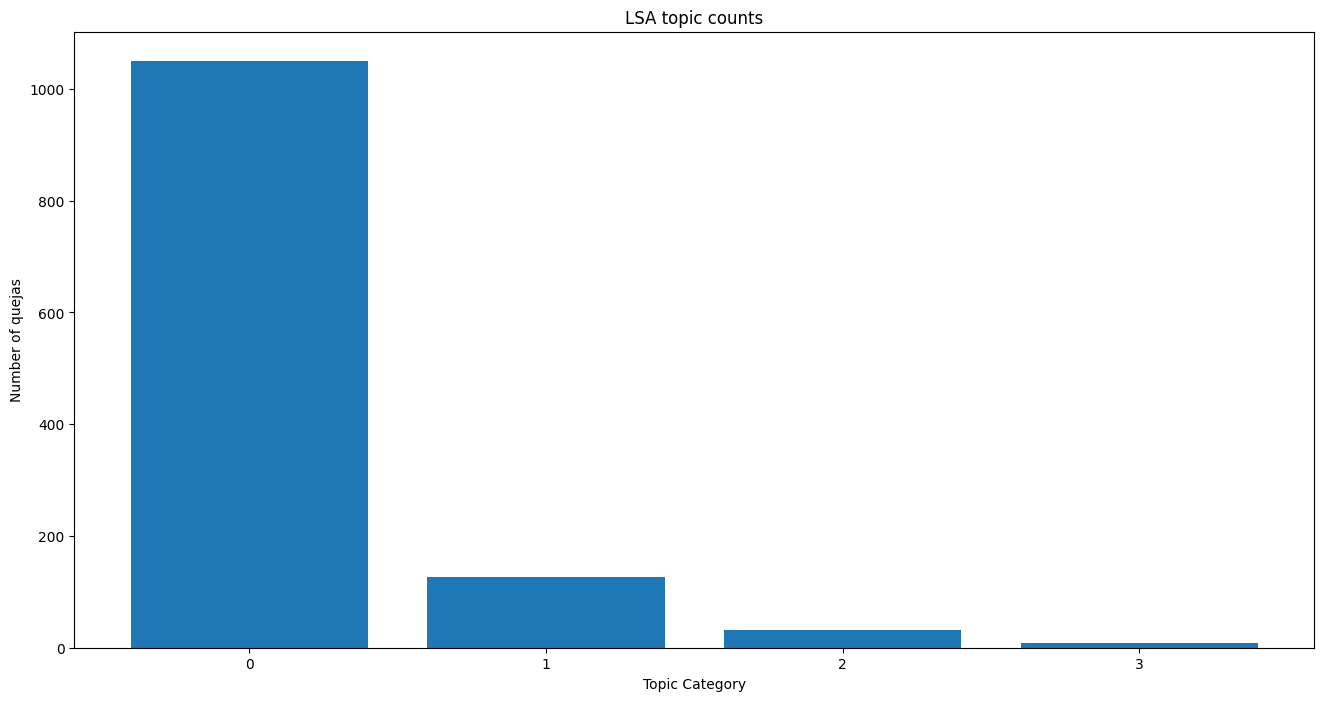

In [17]:
top_n_words = get_top_n_words(5, lsa_keys, document_term_matrix, vectorizer)
labels = ['Topic {}: \n'.format(i) + top_n_words[i] for i in lsa_categories]

print("Topic Labels:")
for i, category in enumerate(lsa_categories):
    label = "Topic {}: \n".format(i) + top_n_words[i]
    print(label)

# Create the bar chart with unformatted category labels
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xlabel('Topic Category');  # Change label to 'Topic Category'
ax.set_ylabel('Number of quejas');
ax.set_title('LSA topic counts');
plt.show()

Para entender mejor los tópicos identificados por LSA, visualizamos la distribución de documentos por cada tópico y la agrupación de estos documentos en un espacio bidimensional usando t-SNE (t-distributed Stochastic Neighbor Embedding). Los centroides de los clústeres, etiquetados con las 5 palabras principales de cada tópico, ayudan a interpretar los temas.

El gráfico t-SNE revelará si los tópicos forman clústeres distintivos

In [18]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1217 samples in 0.007s...
[t-SNE] Computed neighbors for 1217 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1217
[t-SNE] Computed conditional probabilities for sample 1217 / 1217
[t-SNE] Mean sigma: 0.918534
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.742493
[t-SNE] KL divergence after 2000 iterations: 0.619417


In [19]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])

        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [20]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [21]:
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

# Define el color del texto de las etiquetas en negro
text_color = "black"

for t in range(n_topics):
  label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                text=top_n_words[t], text_color=text_color)
  plot.add_layout(label)

show(plot)

print("\nTopic Labels:")
for i, topic in enumerate(lsa_categories):
  label = "Topic {}:".format(i) + top_n_words[i]
  print(label)


Topic Labels:
Topic 0:bbva millones año empresas banco
Topic 1:inflación precios año alimentos ipc
Topic 2:energía agua electricidad eléctrica puede
Topic 3:datos información clientes ciencia modelos


### Búsqueda de hiperparámetros

La búsqueda de hiperparámetros es un paso crítico para encontrar la configuración óptima del modelo LSA. Utilizamos GridSearchCV para explorar sistemáticamente diferentes valores para el número de componentes.

La métrica más adecuada para LSA en un contexto no supervisado es el error de reconstrucción (o su negativo).

#### Optimización LSA usando Error de reconstrucción

Esta métrica evalúa qué tan bien el modelo puede representar los datos originales en un espacio de menor dimensión y luego reconstruirlos. Un menor error de reconstrucción (o un valor negativo maximizado) indica un modelo que preserva mejor la información del corpus.

**Nota sobre la implementación:** Aunque conceptualmente el 'error de reconstrucción' es la métrica correcta, la implementación de GridSearchCV con scorers personalizados para modelos no supervisados en Scikit-learn puede presentar desafíos, como se observa en los resultados nan. Esto a menudo se debe a cómo GridSearchCV espera un y_true incluso si el scorer no lo usa directamente. La función make_scorer puede requerir una configuración específica (como needs_y=False) o una adaptación para manejar la ausencia de y de manera explícita en el pipeline del modelo no supervisado. A pesar de los resultados nan en la ejecución de ejemplo, el método lsa_reconstruction_scorer sigue siendo la aproximación teóricamente correcta.

In [22]:
# Se define un scorer no supervisado basado en error de reconstrucción.
def lsa_reconstruction_scorer(estimator, X, y=None):
    # Se extraen pasos del pipeline
    vec = estimator.named_steps['vectorizer']
    lsa = estimator.named_steps['lsa']
    # Se vectoriza el conjunto de validación
    X_dtm = vec.transform(X)
    # Se proyecta y reconstruye
    X_proj = lsa.transform(X_dtm)
    X_recon = lsa.inverse_transform(X_proj)
    # Se calcula MSE de reconstrucción (menor = mejor).
    # Se devuelve NEGADO para que GridSearchCV maximice el score.
    return -mean_squared_error(X_dtm.toarray(), X_recon)

recon_scorer = make_scorer(lsa_reconstruction_scorer, greater_is_better=True)

# Pipeline: vectorización + LSA
lsa_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=spanish_stop_words,
                                   max_features=40000,   # ajusta si hay memoria justa
                                   ngram_range=(1,1))), # unigramas típicos para LSA básico
    ('lsa', TruncatedSVD(random_state=42, algorithm='randomized'))
])

# Rango de parámetros a explorar
lsa_param_grid = {
    'lsa__n_components': [3, 4, 5, 6, 7, 8, 10, 15]
}

lsa_search = GridSearchCV(
    lsa_pipeline,
    param_grid=lsa_param_grid,
    cv=3,
    scoring=recon_scorer,   # <- scorer no supervisado
    n_jobs=-1,
    verbose=2
)

lsa_search.fit(data['news'])
print("Mejores parámetros LSA:", lsa_search.best_params_)
print("Mejor (−MSE) de reconstrucción (cv):", lsa_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejores parámetros LSA: {'lsa__n_components': 3}
Mejor (−MSE) de reconstrucción (cv): nan


## **Latent Dirichilet Allocation**

A diferencia de LSA, LDA es un modelo probabilístico generativo diseñado para descubrir la estructura temática latente en un corpus de texto. Asume que cada documento es una mezcla de tópicos, y cada tópico es una mezcla de palabras. Este enfoque bayesiano permite una interpretación probabilística de la asignación de palabras a tópicos y de tópicos a documentos.

Repetiremos el proceso de identificación y visualización de tópicos, esta vez utilizando LDA.

In [23]:
n_topics = 4
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online',
                                          random_state=0, verbose=0)

lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [24]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

Al igual que con LSA, visualizamos la distribución de noticias por tópico y la agrupación de estas utilizando t-SNE para evaluar la claridad y separación de los temas generados por LDA. Las etiquetas de los centroides con las 5 palabras principales de cada tópico nos ayudan a interpretar el contenido temático.

In [25]:
top_n_words_lda = get_top_n_words(5, lda_keys, document_term_matrix, vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  inflación precios año millones mayor
Topic 2:  energía agua bbva puede sostenible
Topic 3:  bbva empresas clientes banco colombia
Topic 4:  mujeres cine avianca millones viva


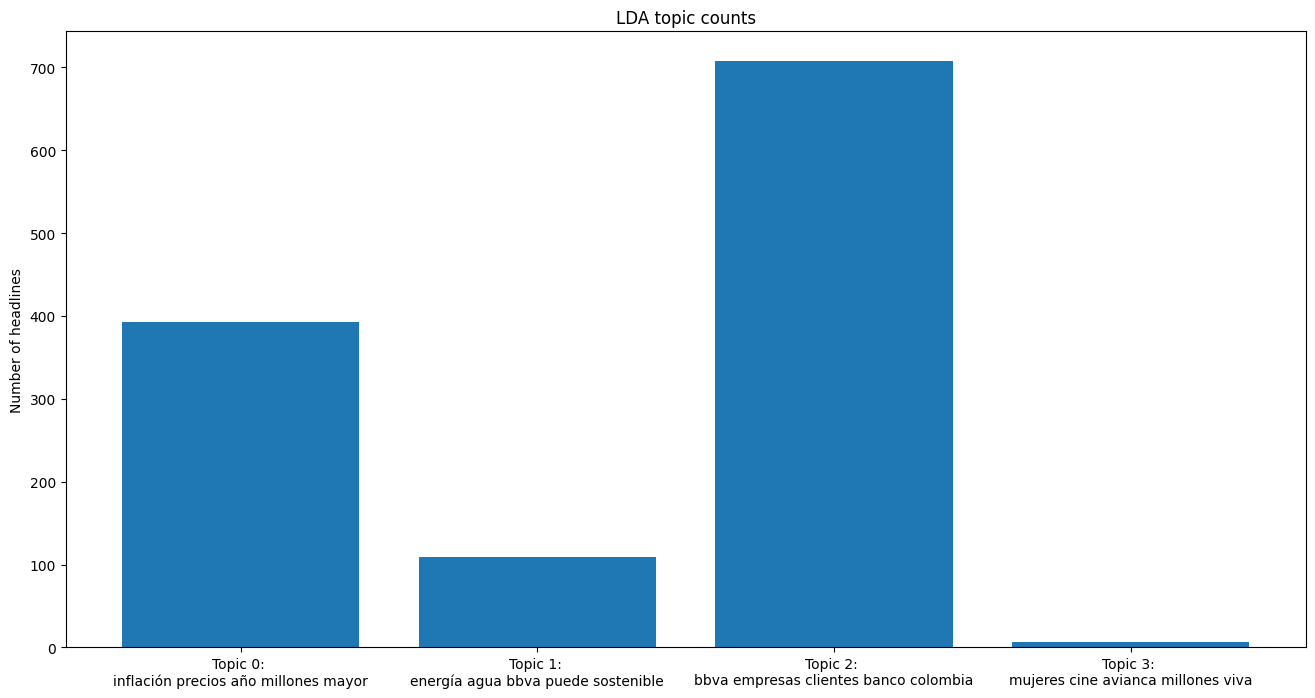

In [26]:
labels = ['Topic {}: \n'.format(i) + top_n_words_lda[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [27]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1217 samples in 0.002s...
[t-SNE] Computed neighbors for 1217 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1217
[t-SNE] Computed conditional probabilities for sample 1217 / 1217
[t-SNE] Mean sigma: 0.000654
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.313885
[t-SNE] KL divergence after 2000 iterations: 0.164075


In [28]:
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

text_color = "black"

for t in range(n_topics):
  label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                text=top_n_words_lda[t], text_color=text_color)
  plot.add_layout(label)

show(plot)

print("\n Topic Labels:")
for i, topic in enumerate(lda_categories):
  label = "Topic {}:".format(i) + top_n_words_lda[i]
  print(label)


 Topic Labels:
Topic 0:inflación precios año millones mayor
Topic 1:energía agua bbva puede sostenible
Topic 2:bbva empresas clientes banco colombia
Topic 3:mujeres cine avianca millones viva


#### Búsqueda de hiperparámetros

Optimizar los hiperparámetros de LDA es crucial para obtener tópicos coherentes y bien definidos. Exploramos diferentes configuraciones para el número de tópicos (n_components), el método de aprendizaje (learning_method) y el decaimiento del aprendizaje (learning_decay).

Para LDA, las métricas más robustas y comúnmente aceptadas son la perplejidad (a minimizar) y la coherencia de tópicos (C_v) (a maximizar). La perplejidad mide qué tan bien el modelo predice el conjunto de datos (menor es mejor), mientras que la coherencia C_v evalúa la interpretabilidad de los tópicos al medir la similitud semántica de sus palabras más prominentes (mayor es mejor).

También se puede utilizar el log-likelihood (a maximizar), que indica la probabilidad de que el modelo haya generado el corpus observado. Sin embargo, la coherencia C_v a menudo se correlaciona mejor con la evaluación humana de la calidad de los tópicos.

##### 1. Optimización de LDA usando Perplexity

La perplejidad es una métrica estadística que mide cuán bien un modelo probabilístico predice un conjunto de datos, siendo un valor menor, mejor.

In [29]:
# Rango de hiperparámetros a probar
param_grid = {
    "n_components": [3, 4, 5, 6, 7, 8, 9, 10],  # número de tópicos
    "learning_decay": [0.5, 0.7, 0.9],         # factor de aprendizaje
    "learning_method": ["online", "batch"]     # método de entrenamiento
}

best_perplexity = float("inf")
best_model_perplexity = None
best_params_perplexity = None

# Bucle de búsqueda
for n in param_grid["n_components"]:
    for decay in param_grid["learning_decay"]:
        for method in param_grid["learning_method"]:
            lda = LatentDirichletAllocation(
                n_components=n,
                learning_decay=decay,
                learning_method=method,
                random_state=0 # Se fija random_state para reproducibilidad [22-24]
            )
            lda.fit(document_term_matrix)

            perplexity = lda.perplexity(document_term_matrix)
            print(f"n={n}, decay={decay}, method={method} → perplexity={perplexity:.2f}")

            if perplexity < best_perplexity:
                best_perplexity = perplexity
                best_model_perplexity = lda
                best_params_perplexity = {"n_components": n, "learning_decay": decay, "learning_method": method}

print("\nMejores parámetros LDA (Perplejidad):", best_params_perplexity)
print("Mejor perplexity:", best_perplexity)

n=3, decay=0.5, method=online → perplexity=5689.91
n=3, decay=0.5, method=batch → perplexity=5684.89
n=3, decay=0.7, method=online → perplexity=5648.63
n=3, decay=0.7, method=batch → perplexity=5684.89
n=3, decay=0.9, method=online → perplexity=5706.51
n=3, decay=0.9, method=batch → perplexity=5684.89
n=4, decay=0.5, method=online → perplexity=5636.15
n=4, decay=0.5, method=batch → perplexity=5674.37
n=4, decay=0.7, method=online → perplexity=5598.67
n=4, decay=0.7, method=batch → perplexity=5674.37
n=4, decay=0.9, method=online → perplexity=5688.34
n=4, decay=0.9, method=batch → perplexity=5674.37
n=5, decay=0.5, method=online → perplexity=5616.72
n=5, decay=0.5, method=batch → perplexity=5684.23
n=5, decay=0.7, method=online → perplexity=5591.17
n=5, decay=0.7, method=batch → perplexity=5684.23
n=5, decay=0.9, method=online → perplexity=5720.10
n=5, decay=0.9, method=batch → perplexity=5684.23
n=6, decay=0.5, method=online → perplexity=5600.63
n=6, decay=0.5, method=batch → perplexit

En este caso el número de tópicos es de 6.

##### 2. Optimización de LDA usando Coherencia de Tópicos (C_v)

La coherencia de tópicos (C_v) evalúa la interpretabilidad de los tópicos midiendo la similitud semántica de sus palabras más prominentes, siendo un valor mayor, mejor. Este enfoque utiliza la librería gensim.

In [30]:
#Prepara los textos como listas de palabras ---
texts = [doc.split() for doc in data['news']]

#Diccionario y corpus en formato gensim ---
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

#Definir rango de hiperparámetros a evaluar
param_grid_coherence = {
    "num_topics": [3, 4, 5, 6, 7, 8, 9, 10],  # número de tópicos
    "passes": [5, 10, 19],    # número de pasadas sobre el corpus
    "alpha": ['symmetric', 'asymmetric'], # priors de distribución
}

best_coherence = -1
best_model_coherence = None
best_params_coherence = None

# --- 4. Bucle de búsqueda --- [27]
for n in param_grid_coherence["num_topics"]:
    for p in param_grid_coherence["passes"]:
        for a in param_grid_coherence["alpha"]:
            lda_model = gensim.models.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=n,
                passes=p,
                alpha=a,
                random_state=0, # Se fija random_state para reproducibilidad
                eval_every=None # Se desactiva evaluación interna
            )
            coherence_model = CoherenceModel(
                model=lda_model,
                texts=texts,
                dictionary=dictionary,
                coherence='c_v'
            )
            coherence_score = coherence_model.get_coherence()

            print(f"n={n}, passes={p}, alpha={a} → coherence={coherence_score:.4f}")

            if coherence_score > best_coherence:
                best_coherence = coherence_score
                best_model_coherence = lda_model
                best_params_coherence = {"num_topics": n, "passes": p, "alpha": a}

print("\nMejores parámetros (Coherencia C_v):", best_params_coherence)
print("Mejor coherencia (C_v):", best_coherence)

n=3, passes=5, alpha=symmetric → coherence=0.2147
n=3, passes=5, alpha=asymmetric → coherence=0.2147
n=3, passes=10, alpha=symmetric → coherence=0.2158
n=3, passes=10, alpha=asymmetric → coherence=0.2158
n=3, passes=19, alpha=symmetric → coherence=0.2204


n=3, passes=19, alpha=asymmetric → coherence=0.2158


n=4, passes=5, alpha=symmetric → coherence=0.2146
n=4, passes=5, alpha=asymmetric → coherence=0.2146
n=4, passes=10, alpha=symmetric → coherence=0.2041
n=4, passes=10, alpha=asymmetric → coherence=0.2586
n=4, passes=19, alpha=symmetric → coherence=0.2531


n=4, passes=19, alpha=asymmetric → coherence=0.3806


n=5, passes=5, alpha=symmetric → coherence=0.2145
n=5, passes=5, alpha=asymmetric → coherence=0.2146
n=5, passes=10, alpha=symmetric → coherence=0.2166
n=5, passes=10, alpha=asymmetric → coherence=0.2172
n=5, passes=19, alpha=symmetric → coherence=0.2388


n=5, passes=19, alpha=asymmetric → coherence=0.2363


n=6, passes=5, alpha=symmetric → coherence=0.2156
n=6, passes=5, alpha=asymmetric → coherence=0.2149
n=6, passes=10, alpha=symmetric → coherence=0.2115
n=6, passes=10, alpha=asymmetric → coherence=0.2134
n=6, passes=19, alpha=symmetric → coherence=0.2498


n=6, passes=19, alpha=asymmetric → coherence=0.2400


n=7, passes=5, alpha=symmetric → coherence=0.2155
n=7, passes=5, alpha=asymmetric → coherence=0.2154
n=7, passes=10, alpha=symmetric → coherence=0.2204
n=7, passes=10, alpha=asymmetric → coherence=0.2196
n=7, passes=19, alpha=symmetric → coherence=0.2912


n=7, passes=19, alpha=asymmetric → coherence=0.2633


n=8, passes=5, alpha=symmetric → coherence=0.2154
n=8, passes=5, alpha=asymmetric → coherence=0.2154
n=8, passes=10, alpha=symmetric → coherence=0.2289
n=8, passes=10, alpha=asymmetric → coherence=0.2198
n=8, passes=19, alpha=symmetric → coherence=0.2717


n=8, passes=19, alpha=asymmetric → coherence=0.2705


n=9, passes=5, alpha=symmetric → coherence=0.2154
n=9, passes=5, alpha=asymmetric → coherence=0.2151
n=9, passes=10, alpha=symmetric → coherence=0.2398
n=9, passes=10, alpha=asymmetric → coherence=0.2338
n=9, passes=19, alpha=symmetric → coherence=0.3259


n=9, passes=19, alpha=asymmetric → coherence=0.3588


n=10, passes=5, alpha=symmetric → coherence=0.2149
n=10, passes=5, alpha=asymmetric → coherence=0.2145
n=10, passes=10, alpha=symmetric → coherence=0.2320
n=10, passes=10, alpha=asymmetric → coherence=0.2337
n=10, passes=19, alpha=symmetric → coherence=0.3299
n=10, passes=19, alpha=asymmetric → coherence=0.3321

Mejores parámetros (Coherencia C_v): {'num_topics': 4, 'passes': 19, 'alpha': 'asymmetric'}
Mejor coherencia (C_v): 0.3805600103237736


En este caso el número de tópicos es de 6.

##### Optimización de LDA usando Log-likelihood con GridSearchCV

El log-likelihood (a maximizar) indica la probabilidad de que el modelo haya generado el corpus observado. Este método utiliza GridSearchCV de sklearn con un scorer personalizado.

In [31]:
# Se asegura la lista de textos de entrada; se asume que 'data' posee la columna 'news'.
texts = data['news'].astype(str).tolist()

# Se definen las stopwords en español; si ya existen en memoria, se reutilizan.
try:
    spanish_stop_words = spanish_stop_words
except NameError:
    from nltk.corpus import stopwords
    spanish_stop_words = stopwords.words('spanish')

# Se construye el pipeline Vectorizador (BoW) -> LDA con parámetros base reproducibles.
lda_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        stop_words=spanish_stop_words,   # Se eliminan palabras vacías en español.
        max_features=40000,              # Se limita el vocabulario por memoria/ruido.
        ngram_range=(1,1)                # Se emplean unigramas (recomendado para LDA clásico).
    )),
    ('lda', LatentDirichletAllocation(
        random_state=42,                 # Se fija semilla para reproducibilidad.
        max_iter=20,                     # Se fija número de iteraciones EM.
        evaluate_every=0,                # Se desactiva evaluación interna (la hace GridSearch).
        n_jobs=-1                        # Se paraleliza cuando es posible.
    ))
])

# Se define un scorer no supervisado que maximiza el log-likelihood de LDA sobre X_val.
def lda_loglik_scorer(estimator, X, y=None):
    # Se obtiene el vectorizador y el modelo ya ajustados en el fold de entrenamiento.
    vec = estimator.named_steps['vectorizer']
    lda = estimator.named_steps['lda']
    # Se transforma el conjunto de validación a matriz documento–término (DTM).
    X_dtm = vec.transform(X)
    # Se retorna el log-likelihood del modelo sobre la DTM (valor mayor es mejor).
    return lda.score(X_dtm)

# Se envuelve el scorer para que GridSearch lo maximice.
loglik_scorer = make_scorer(lda_loglik_scorer, greater_is_better=True)

# Se define la grilla de hiperparámetros a explorar.
# Nota: 'learning_decay' solo aplica a 'online'; para 'batch' se ignora sin afectar el scoring.
lda_param_grid = {
    'lda__n_components': [3, 4, 6, 8, 10, 15, 20],  # Se exploran tamaños de K.
    'lda__learning_method': ['online', 'batch'],    # Se compara 'online' vs 'batch'.
    'lda__learning_decay': [0.5, 0.7, 0.9]          # Se prueba decaimiento (si 'online').
}

# (Opcional) Se realiza muestreo si el corpus es grande para acelerar la búsqueda.
rng = np.random.RandomState(42)
n = len(texts)
frac = 1.0 if n <= 8000 else 0.3          # Se usa 30% para corpus grandes.
subset_idx = rng.choice(n, size=int(n*frac), replace=False)
texts_sample = [texts[i] for i in subset_idx]

# Se configura la búsqueda con validación cruzada y el scorer no supervisado.
lda_search = GridSearchCV(
    lda_pipeline,
    param_grid=lda_param_grid,
    cv=3,
    scoring=loglik_scorer,   # <- Se corrige la métrica: log-likelihood en lugar de MSE.
    n_jobs=-1,
    verbose=2
)

# Se ajusta la búsqueda sobre el subconjunto (o el total si n es pequeño).
lda_search.fit(texts_sample)

# Se imprimen los mejores hiperparámetros y el mejor score de validación cruzada.
print("Mejores parámetros LDA:", lda_search.best_params_)
print("Mejor log-likelihood (cv):", lda_search.best_score_)

# Se reentrena el mejor pipeline sobre TODO el corpus para producir el modelo final.
best_lda_pipeline = lda_search.best_estimator_
best_lda_pipeline.fit(texts)

# Se derivan objetos útiles para análisis posterior (DTM, distribución doc-tópico, vocabulario, etc.).
best_vec = best_lda_pipeline.named_steps['vectorizer']
best_lda = best_lda_pipeline.named_steps['lda']
DTM = best_vec.transform(texts)                # Se obtiene la DTM final.
THETA = best_lda.transform(DTM)                # Se calcula distribución de tópicos por documento.
PHI = best_lda.components_                     # Se extraen pesos palabra por tópico.
vocab = np.array(best_vec.get_feature_names_out())

# (Opcional) Se listan las top palabras por tópico para inspección.
def top_words_per_topic(phi, vocab, topn=10):
    tops = []
    for k in range(phi.shape[0]):
        top_idx = np.argsort(phi[k])[::-1][:topn]
        tops.append(vocab[top_idx].tolist())
    return tops

top10 = top_words_per_topic(PHI, vocab, topn=10)
for k, words in enumerate(top10, 1):
    print(f"Tópico {k:02d}: {', '.join(words)}")

Fitting 3 folds for each of 42 candidates, totalling 126 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Mejores parámetros LDA: {'lda__learning_decay': 0.5, 'lda__learning_method': 'online', 'lda__n_components': 3}
Mejor log-likelihood (cv): nan
Tópico 01: inflación, año, precios, mayor, millones, crecimiento, alimentos, tasa, aumento, mes
Tópico 02: regulación, dijo, trabajo, si, criptomonedas, gobierno, ley, plataformas, ser, dos
Tópico 03: bbva, empresas, clientes, banco, colombia, millones, además, través, 000, desarrollo


En este caso el número de tópicos es de 3.

# Conclusiones

- **LSA** permite una representación reducida del espacio semántico, útil para identificar patrones globales,
  pero sus tópicos pueden ser difíciles de interpretar.
- **LDA** genera distribuciones más interpretables por documento y palabra.
- El dataset en español presenta desafíos: variaciones morfológicas, palabras compuestas y necesidad de un preprocesamiento robusto.
- La **coherencia** ayuda a seleccionar el número óptimo de tópicos, aunque no debe usarse de forma aislada: la interpretabilidad es clave.
